# SCARF: Self-Supervised Contrastive Learning using Random Feature Corruption

![image](SCARF_Schema.png)

This file contains an implementation of SCARF on two publicly available datasets: [Darwin dataset](https://archive.ics.uci.edu/dataset/732/darwin)and [Nomao dataset](https://archive.ics.uci.edu/dataset/227/nomao). 
Nomao dataset contains 451 features across 174 participants with 2 classes: Alzheimer's disease patients or healthy.

The goal is to  learn a tabular data representation in an unsupervised or self-supervised such that the learnt representations can be good at the classification task.

Adapted from [pytorch implementation of SCARF](https://github.com/clabrugere/pytorch-scarf/tree/master).

In [1]:
# importing packages
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import random
import os
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm
from scarf import scarf_model, loss
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xgboost as xgb

/home/trips/Virtual_env_python/lib64/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# check the current directory, set it as scarf
if os.getcwd()!= '/home/trips/ContrastiveLearning_Tutorial/scarf':  # replace the path with your local path
    os.chdir('/home/trips/ContrastiveLearning_Tutorial/scarf')
print("Current working directory is : ", os.getcwd())

Current working directory is :  /home/trips/ContrastiveLearning_Tutorial/scarf


In [86]:
# function for initial loading and processing of the dataset
def load_dataset(dataset):
    if dataset=='Darwin':
        data_file = os.path.join('../Small_datasets', dataset, dataset + ".csv")
        df = pd.read_csv(data_file)

        # convert the target into numeric
        df.loc[df['class']=='P','class']=1
        df.loc[df['class']=='H','class']=0

        df['class'] = df['class'].astype(int)
        df['class'] = df['class'].astype(int)

        data, target = df.iloc[:,1:-1], df.iloc[:,-1]  # first column is the id and last column is the target
        
    if dataset=='Nomao':
        data_file = os.path.join('../Small_datasets', dataset, dataset + ".data")

        full_Data0 = pd.read_csv(data_file, header=None)
        full_Data0.replace('?', np.nan, inplace=True)
        full_Data0 = full_Data0.loc[:, ~(full_Data0 == 'n').any()]  # dropping the nominal type columns
        full_Data0.drop(columns=[0], inplace=True)  # dropping the id column

        # drop columns with very high missing percentage
        percent_missing = full_Data0.isnull().sum() * 100 / len(full_Data0)
        missing_value_df = pd.DataFrame({'column_name': full_Data0.columns,
                                         'percent_missing': percent_missing}).sort_values(by='percent_missing')
        full_Data0 = full_Data0[missing_value_df[missing_value_df['percent_missing'] < 70.0]['column_name']]

        ## final columns that were selected including the label and excluding the first column that was the id
        ## [1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 62, 65, 66, 67, 68, 69,
        # 70, 73, 74, 75, 76, 77, 78, 81, 82, 83, 84, 85, 86, 89, 90, 91, 97, 98, 99, 101, 102, 103, 105, 106, 107, 109,
        # 110, 111, 113, 114, 115, 117, 118, 119]

        full_Data0 = full_Data0.reindex(columns=sorted(full_Data0.columns))  # reindexing so that label is at the end
        new_feature_names = ['Col' + str(i + 1) for i in range(full_Data0.shape[1] - 1)] 
        full_Data0 = full_Data0.set_axis(new_feature_names+ ['Y'], axis=1)  # renamed the continuous columns

        # converting the columns that are being treated as object type but actually are float
        for a in full_Data0.columns:
            if full_Data0[a].dtype == 'object':
                full_Data0[a] = full_Data0[a].astype('float')

        full_Data0 = full_Data0.fillna(full_Data0.mean())  # filling the missing values
        full_Data0['Y'] = np.where(full_Data0['Y'] == -1, 0, 1)  # to make it compatible with the rest
        
        data, target = full_Data0[new_feature_names], full_Data0['Y']
        

    train_data, test_data, train_target, test_target = train_test_split(
        data, 
        target, 
        test_size=0.2, 
        stratify=target, 
        random_state=seed
    )

    # preprocess
    constant_cols = [c for c in train_data.columns if train_data[c].nunique() == 1]
    train_data.drop(columns=constant_cols, inplace=True)
    test_data.drop(columns=constant_cols, inplace=True)

    scaler = StandardScaler()
    train_data = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)
    test_data = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)

    # to torch dataset
    train_ds = scarf_model.ExampleDataset(
        train_data.to_numpy(), 
        train_target.to_numpy(), 
        columns=train_data.columns
    )
    test_ds = scarf_model.ExampleDataset(
        test_data.to_numpy(), 
        test_data.to_numpy(), 
        columns=test_data.columns
    )

#     print(f"Train set: {train_ds.shape}")
#     print(f"Test set: {test_ds.shape}")
    train_ds.to_dataframe().head()

    return train_data, train_ds, train_target,test_data, test_ds, test_target


In [87]:
# initial setting and the dataset choice

dataset = "Darwin" # dataset name  {'Darwin', 'Nomao'}
batch_size=128
epochs = 10000
lr=0.001  # learning rate
repr_dims= 100  # representation dimension
seed = 100  # random seed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
corruptionRate = 0.6

In [88]:
# loading data, orig_tr and orig_te is the form without anchor etc
orig_tr, train_data, train_labels,orig_te, test_data, test_labels = load_dataset(dataset)

# data dimensions 
print(" Training data size :  ", train_data.shape)  # Number of samples *  number of features
print(" Test data size :  ", test_data.shape)
print(" Class prevalence : ", (train_labels.sum() + test_labels.sum() )/(train_data.shape[0] +test_data.shape[0]) )

 Training data size :   (139, 450)
 Test data size :   (35, 450)
 Class prevalence :  0.5114942528735632


In [89]:
# Setting up the data laoder and initializing the models
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = scarf_model.SCARF(
    input_dim=train_data.shape[1], 
    emb_dim=repr_dims,
    corruption_rate=corruptionRate,
).to(device)
optimizer = Adam(model.parameters(), lr=lr)
ntxent_loss = loss.NTXent()

In [90]:
# fitting the model
loss_history = []

for epoch in range(1, epochs + 1):
    epoch_loss = scarf_model.train_epoch(model, ntxent_loss, train_loader, optimizer, device, epoch)
    loss_history.append(epoch_loss)

Text(0, 0.5, 'loss')

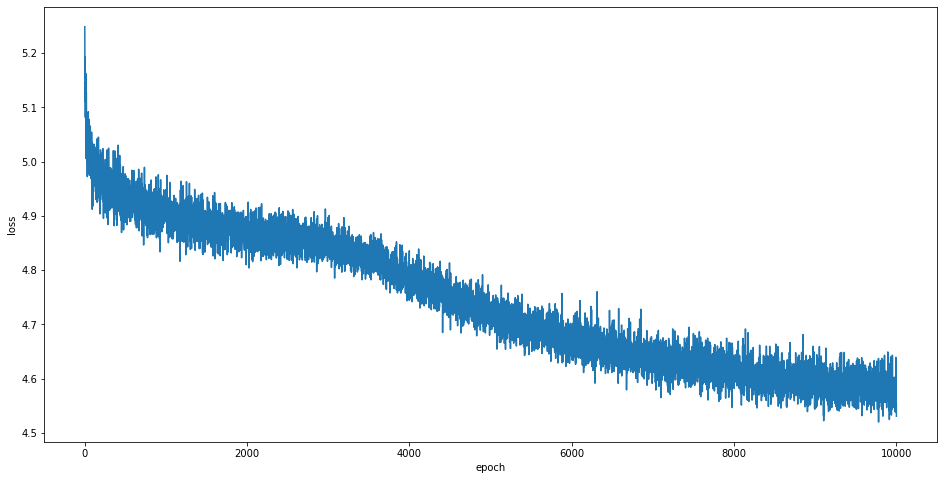

In [91]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(loss_history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")

In [92]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# get embeddings for training and test set
train_embeddings = scarf_model.dataset_embeddings(model, train_loader, device)
test_embeddings = scarf_model.dataset_embeddings(model, test_loader, device)

print(train_embeddings.shape)
print(test_embeddings.shape)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 690.65it/s]

(139, 100)
(35, 100)


## Visualize the embeddings using t-sne

/home/trips/Virtual_env_python/lib64/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Text(0.5, 1.0, 'Dataset : Darwin \n tsne reduced representation of time series')

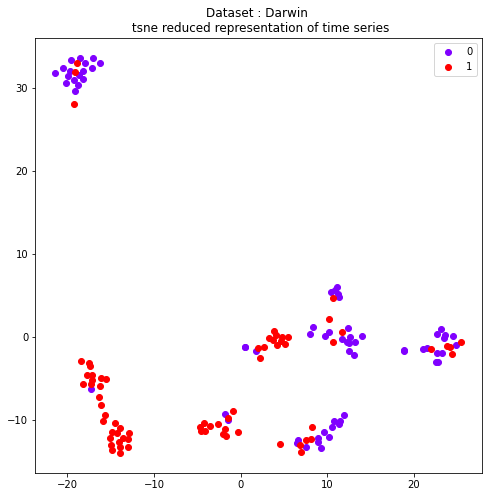

In [93]:
tsne = TSNE(n_components=2, learning_rate="auto", init="pca", perplexity=15)
reduced = tsne.fit_transform(train_embeddings)

# obtaining unique labels
unique_labels = np.unique(train_labels)

fig, ax = plt.subplots(figsize=(8, 8))

colors = cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, col in zip(unique_labels, colors):
    indices = [i for i, l in enumerate(train_labels) if l == label]
    
    current_tx = np.take(reduced[:,0], indices)
    current_ty = np.take(reduced[:,1], indices)
    
    ax.scatter(current_tx, current_ty, color=col, label=label)
    
# build a legend using the labels we set previously
plt.legend(loc='best')
plt.title("Dataset : "+dataset +" \n tsne reduced representation of time series")

## Linear evaluation

In [94]:
# RF classifier 
clf_rf = RandomForestClassifier(max_depth=6, random_state=0)
clf_rf.fit(orig_tr, train_labels)

vanilla_predictions = clf_rf.predict(orig_te)
y_score = clf_rf.predict_proba(orig_te)
auprc = average_precision_score(test_labels, y_score[:,1])
auroc = roc_auc_score(test_labels, y_score[:,1])

print("Dataset : ", dataset, " performance on the original data with a RF classifier" )
print(" Accuracy : ", clf_rf.score(orig_te, test_labels))
print('AUROC: ', auroc)
print('AUPRC: ', auprc) 
print(' result summary ')
print(classification_report(test_labels, vanilla_predictions))

Dataset :  Darwin  performance on the original data with a RF classifier
 Accuracy :  0.8857142857142857
AUROC:  0.9738562091503268
AUPRC:  0.9769899626517274
 result summary 
              precision    recall  f1-score   support

           0       0.93      0.82      0.87        17
           1       0.85      0.94      0.89        18

    accuracy                           0.89        35
   macro avg       0.89      0.88      0.88        35
weighted avg       0.89      0.89      0.89        35



In [95]:
# on the learnt embeddings

clf_rf = RandomForestClassifier(n_estimators=100,max_depth=6, random_state=0)
clf_rf.fit(train_embeddings, train_labels.values)

vanilla_predictions = clf_rf.predict(test_embeddings)
y_score = clf_rf.predict_proba(test_embeddings)
auprc = average_precision_score(test_labels, y_score[:,1])
auroc = roc_auc_score(test_labels, y_score[:,1])

print("Dataset : ", dataset, " performance on the learnt embeddings with a RF classifier" )
print(" Accuracy : ", clf_rf.score(test_embeddings, test_labels))
print('AUROC: ', auroc)
print('AUPRC: ', auprc)
print(' result summary ')
print(classification_report(test_labels, vanilla_predictions))

Dataset :  Darwin  performance on the learnt embeddings with a RF classifier
 Accuracy :  0.6857142857142857
AUROC:  0.7941176470588235
AUPRC:  0.7947361222865629
 result summary 
              precision    recall  f1-score   support

           0       0.71      0.59      0.65        17
           1       0.67      0.78      0.72        18

    accuracy                           0.69        35
   macro avg       0.69      0.68      0.68        35
weighted avg       0.69      0.69      0.68        35



In [96]:
# xgb classifier
clf = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1)
clf.fit(orig_tr, train_labels)

vanilla_predictions = clf.predict(orig_te)
y_score = clf.predict_proba(orig_te)
auprc = average_precision_score(test_labels, y_score[:,1])
auroc = roc_auc_score(test_labels, y_score[:,1])

print("Dataset : ", dataset, " performance on the original data with a XGBT classifier" )
print(" Accuracy : ", clf.score(orig_te, test_labels))
print('AUROC: ', auroc)
print('AUPRC: ', auprc) 
print(' result summary ')
print(classification_report(test_labels, vanilla_predictions))

Dataset :  Darwin  performance on the original data with a XGBT classifier
 Accuracy :  0.8857142857142857
AUROC:  0.9705882352941175
AUPRC:  0.9762844952795934
 result summary 
              precision    recall  f1-score   support

           0       0.93      0.82      0.87        17
           1       0.85      0.94      0.89        18

    accuracy                           0.89        35
   macro avg       0.89      0.88      0.88        35
weighted avg       0.89      0.89      0.89        35



In [97]:
# xgb classifier
clf = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.01)
clf.fit(train_embeddings, train_labels)

vanilla_predictions = clf.predict(test_embeddings)
y_score = clf.predict_proba(test_embeddings)
auprc = average_precision_score(test_labels, y_score[:,1])
auroc = roc_auc_score(test_labels, y_score[:,1])

print("Dataset : ", dataset, " performance on the learnt embeddings with a XGBT classifier" )
print(" Accuracy : ", clf.score(test_embeddings, test_labels))
print('AUROC: ', auroc)
print('AUPRC: ', auprc) 
print(' result summary ')
print(classification_report(test_labels, vanilla_predictions))

Dataset :  Darwin  performance on the learnt embeddings with a XGBT classifier
 Accuracy :  0.7142857142857143
AUROC:  0.727124183006536
AUPRC:  0.7055961141971204
 result summary 
              precision    recall  f1-score   support

           0       0.77      0.59      0.67        17
           1       0.68      0.83      0.75        18

    accuracy                           0.71        35
   macro avg       0.73      0.71      0.71        35
weighted avg       0.72      0.71      0.71        35



## Label noise robustness of the embeddings

In [98]:
# corrupting the train labels with a fixed percentage of noise

noise_rate = 0.1

def induce_uniform_label_noise(labels, noise_probability):
    """
    Induce uniform label noise in a dataset.

    Parameters:
    - labels: NumPy array or list containing the original labels.
    - noise_probability: Probability of label noise (0.0 to 1.0).

    Returns:
    - Labels with induced noise.
    """
    noisy_labels = labels.copy()
    num_samples = len(labels)
    num_classes = len(np.unique(labels))
    
    for i in range(num_samples):
        # Generate a random value to determine if label noise should be added
        if np.random.rand() < noise_probability:
            # Choose a random class different from the original label
            new_label = np.random.randint(0, num_classes)
            noisy_labels[i] = new_label

    return noisy_labels

noisy_train_labels = induce_uniform_label_noise(train_labels.values, noise_probability=noise_rate)

print("True positive class prev : ", train_labels.sum()/train_data.shape[0])
print("True positive class prev : ", noisy_train_labels.sum()/train_data.shape[0])

True positive class prev :  0.5107913669064749
True positive class prev :  0.49640287769784175


## Training the classifiers on noisy data 

In [99]:
# RF classifier 
clf_rf = RandomForestClassifier(max_depth=6, random_state=0)
clf_rf.fit(orig_tr, noisy_train_labels)

vanilla_predictions = clf_rf.predict(orig_te)
y_score = clf_rf.predict_proba(orig_te)
auprc = average_precision_score(test_labels, y_score[:,1])
auroc = roc_auc_score(test_labels, y_score[:,1])

print("Dataset : ", dataset, " performance on the original data with a RF classifier (trained on noisy labels)" )
print(" Accuracy : ", clf_rf.score(orig_te, test_labels))
print('AUROC: ', auroc)
print('AUPRC: ', auprc) 
print(' result summary ')
print(classification_report(test_labels, vanilla_predictions))

Dataset :  Darwin  performance on the original data with a RF classifier (trained on noisy labels)
 Accuracy :  0.8857142857142857
AUROC:  0.9738562091503268
AUPRC:  0.9765704771187228
 result summary 
              precision    recall  f1-score   support

           0       0.93      0.82      0.87        17
           1       0.85      0.94      0.89        18

    accuracy                           0.89        35
   macro avg       0.89      0.88      0.88        35
weighted avg       0.89      0.89      0.89        35



In [100]:
# on the learnt embeddings

clf_rf = RandomForestClassifier(max_depth=6, random_state=0)
clf_rf.fit(train_embeddings, noisy_train_labels)

vanilla_predictions = clf_rf.predict(test_embeddings)
y_score = clf_rf.predict_proba(test_embeddings)
auprc = average_precision_score(test_labels, y_score[:,1])
auroc = roc_auc_score(test_labels, y_score[:,1])

print("Dataset : ", dataset, " performance on the learnt embeddings with a RF classifier (trained on noisy labels)" )
print(" Accuracy : ", clf_rf.score(test_embeddings, test_labels))
print('AUROC: ', auroc)
print('AUPRC: ', auprc)
print(' result summary ')
print(classification_report(test_labels, vanilla_predictions))

Dataset :  Darwin  performance on the learnt embeddings with a RF classifier (trained on noisy labels)
 Accuracy :  0.6285714285714286
AUROC:  0.8104575163398693
AUPRC:  0.866124140021199
 result summary 
              precision    recall  f1-score   support

           0       0.70      0.41      0.52        17
           1       0.60      0.83      0.70        18

    accuracy                           0.63        35
   macro avg       0.65      0.62      0.61        35
weighted avg       0.65      0.63      0.61        35



In [101]:
# xgb classifier
clf = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1)
clf.fit(orig_tr, noisy_train_labels)

vanilla_predictions = clf.predict(orig_te)
y_score = clf.predict_proba(orig_te)
auprc = average_precision_score(test_labels, y_score[:,1])
auroc = roc_auc_score(test_labels, y_score[:,1])

print("Dataset : ", dataset, " performance on the original data with a XGBT classifier (trained on noisy labels)" )
print(" Accuracy : ", clf.score(orig_te, test_labels))
print('AUROC: ', auroc)
print('AUPRC: ', auprc) 
print(' result summary ')
print(classification_report(test_labels, vanilla_predictions))

Dataset :  Darwin  performance on the original data with a XGBT classifier (trained on noisy labels)
 Accuracy :  0.8285714285714286
AUROC:  0.9444444444444444
AUPRC:  0.957242903602665
 result summary 
              precision    recall  f1-score   support

           0       0.87      0.76      0.81        17
           1       0.80      0.89      0.84        18

    accuracy                           0.83        35
   macro avg       0.83      0.83      0.83        35
weighted avg       0.83      0.83      0.83        35



In [102]:
# xgb classifier
clf = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1)
clf.fit(train_embeddings, noisy_train_labels)

vanilla_predictions = clf.predict(test_embeddings)
y_score = clf.predict_proba(test_embeddings)
auprc = average_precision_score(test_labels, y_score[:,1])
auroc = roc_auc_score(test_labels, y_score[:,1])

print("Dataset : ", dataset, " performance on the learnt embeddings with a XGBT classifier (trained on noisy labels)" )
print(" Accuracy : ", clf.score(test_embeddings, test_labels))
print('AUROC: ', auroc)
print('AUPRC: ', auprc) 
print(' result summary ')
print(classification_report(test_labels, vanilla_predictions))

Dataset :  Darwin  performance on the learnt embeddings with a XGBT classifier (trained on noisy labels)
 Accuracy :  0.7428571428571429
AUROC:  0.7483660130718954
AUPRC:  0.7305230854858067
 result summary 
              precision    recall  f1-score   support

           0       0.83      0.59      0.69        17
           1       0.70      0.89      0.78        18

    accuracy                           0.74        35
   macro avg       0.76      0.74      0.74        35
weighted avg       0.76      0.74      0.74        35



## Exercises

1) Since corruption rate is an important component of SCARF, does changing it change the downstream performance?

2) Does using batchsize more than 128 learn better embeddding?

3) What is the noise threshold where you observe that the embeddings based downstream classification worsens?